In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
view_classes = Base.classes.keys()
view_classes

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement   # Class I
Station = Base.classes.station           # Class II

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23')

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
last_12mo_precipitation = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= '2016-08-24').filter(Measurement.date <= '2017-08-23').group_by(Measurement.date).all()
# last_12mo_precipitation

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(last_12mo_precipitation, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date',inplace=True)

# Sort the dataframe by date
precipitation_df.sort_values(by=['Date'])

precipitation_df

,Precipitation
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-19,0.00
2017-08-20,0.00
2017-08-21,0.00


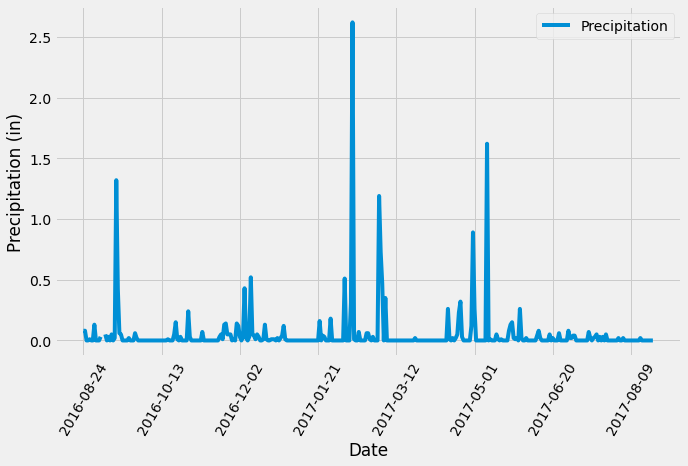

In [25]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x_compat=True, figsize=(10,6))
plt.ylabel("Precipitation (in)")
plt.xlabel("Date")
plt.xticks(rotation='60')
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,363.000000
mean,0.048843
std,0.205197
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.id).count()
station_count

9

In [27]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_results = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
station_results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = station_results[0][0]
station_stats = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
session.query(*station_stats).\
                filter(Measurement.station == most_active).all()

[(54.0, 71.66378066378067, 85.0)]

In [40]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Most recent date
most_recent_date = session.query(Measurement.date).\
                            filter(Measurement.station == most_active).\
                            order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-18')

In [41]:
last_12mo_temp = session.query(Measurement).\
                filter(Measurement.date >= '2016-08-19').\
                filter(Measurement.station == most_active).statement


stmt = session.query(Measurement).\
    filter(Measurement.date > "2016-08-18").\
    filter(Measurement.station == "USC00519281").statement
df2 = pd.read_sql_query(stmt, session.bind)
df2.head()

ObjectNotExecutableError: Not an executable object: [<sqlalchemy.ext.automap.measurement object at 0x000001E1AE2A4B80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE2A4EB0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE711E50>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE711EB0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE711F10>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE711F70>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE711FD0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713070>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7130D0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713130>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713190>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7131F0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713250>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7132B0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713310>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713370>, <sqlalchemy.ext.automap.measurement object at 0x000001E1ACC7D700>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE0A5D00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713400>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713460>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7134C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713520>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713580>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7135E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713640>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7136A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713700>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713760>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7137C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713820>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713880>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7138E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713940>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7139A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713A00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713A60>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713AC0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713B20>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713B80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713BE0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713C40>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713CA0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713D00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713D60>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713DC0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713E20>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713E80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713EE0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713F40>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713FA0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE713FD0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E0A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E100>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E160>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E1C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E220>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E280>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E2E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E340>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E3A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E400>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E460>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E4C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E520>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E580>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E5E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E640>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E6A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E700>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E760>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E7C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E820>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E880>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E8E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E940>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71E9A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71EA00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71EA60>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71EAC0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71EB20>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71EB80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71EBE0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71EC40>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71ECA0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71ED00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71ED60>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71EDC0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71EE20>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71EE80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71EEE0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71EF40>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71EFA0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE71EFD0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B0A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B100>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B160>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B1C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B220>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B280>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B2E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B340>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B3A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B400>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B460>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B4C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B520>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B580>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B5E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B640>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B6A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B700>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B760>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B7C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B820>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B880>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B8E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B940>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72B9A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BA00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BA60>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BAC0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BB20>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BB80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BBE0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BC40>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BCA0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BD00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BD60>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BDC0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BE20>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BE80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BEE0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BF40>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BFA0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE72BFD0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7380A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738100>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738160>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7381C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738220>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738280>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7382E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738340>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7383A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738400>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738460>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7384C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738520>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738580>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7385E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738640>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7386A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738700>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738760>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7387C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738820>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738880>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7388E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738940>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7389A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738A00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738A60>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738AC0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738B20>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738B80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738BE0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738C40>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738CA0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738D00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738D60>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738DC0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738E20>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738E80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738EE0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738F40>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738FA0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE738FD0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7440A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744100>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744160>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7441C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744220>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744280>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7442E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744340>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7443A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744400>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744460>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7444C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744520>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744580>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7445E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744640>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7446A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744700>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744760>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7447C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744820>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744880>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7448E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744940>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7449A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744A00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744A60>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744AC0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744B20>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744B80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744BE0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744C40>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744CA0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744D00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744D60>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744DC0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744E20>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744E80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744EE0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744F40>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744FA0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE744FD0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F0A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F100>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F160>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F1C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F220>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F280>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F2E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F340>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F3A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F400>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F460>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F4C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F520>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F580>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F5E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F640>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F6A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F700>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F760>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F7C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F820>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F880>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F8E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F940>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74F9A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FA00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FA60>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FAC0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FB20>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FB80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FBE0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FC40>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FCA0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FD00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FD60>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FDC0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FE20>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FE80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FEE0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FF40>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FFA0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE74FFD0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D0A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D100>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D160>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D1C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D220>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D280>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D2E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D340>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D3A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D400>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D460>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D4C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D520>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D580>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D5E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D640>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D6A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D700>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D760>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D7C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D820>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D880>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D8E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D940>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75D9A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DA00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DA60>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DAC0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DB20>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DB80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DBE0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DC40>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DCA0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DD00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DD60>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DDC0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DE20>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DE80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DEE0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DF40>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DFA0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE75DFD0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A0A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A100>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A160>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A1C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A220>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A280>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A2E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A340>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A3A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A400>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A460>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A4C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A520>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A580>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A5E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A640>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A6A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A700>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A760>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A7C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A820>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A880>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A8E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A940>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76A9A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76AA00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76AA60>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76AAC0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76AB20>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76AB80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76ABE0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76AC40>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76ACA0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76AD00>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76AD60>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76ADC0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76AE20>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76AE80>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76AEE0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76AF40>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76AFA0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE76AFD0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7760A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE776100>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE776160>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7761C0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE776220>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE776280>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7762E0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE776340>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE7763A0>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE776400>, <sqlalchemy.ext.automap.measurement object at 0x000001E1AE776460>]

In [ ]:
df_12mo_temp = pd.read_sql_query(last_12mo_temp, session.bind)
df12mo_temp.head()

# Close session

In [ ]:
# Close Session
session.close()